## Atmospheric effects on Ground Based Telescope Observing Bands
This notebook uses a python script to calculate and plot CMB instrument sensitivity to fluctuations in atmospheric pwv, given band shapes.

In [1]:
##### import matplotlib.pyplot as plt
#edit
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd

from Atmos_pwv_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [8, 6]

# am model files for Atacama and Pole
Instead of using CH's datacube with information on tb, tx, and frequency, we can upload our own output txt files directly from the am model.  This way we can refine the number of frequency steps, elevation, and look at Jacobian values for pwv in sites. Where the deg is in AZ not EL

input: am ACT_annual_50.amc 0 GHz 600 GHz 0.1 GHz 40 deg 0.0 >> ACT_annual50_0pwv.txt

output: f GHz  tau neper  tx none  Trj K  Tb K

- SPole- 425.426 um pwv at 50% --> tropscale= 0.705 for 300 um, 0.941 for 400 um
- Atacama- 931.525 um pwv at 50% --> tropscale= 0.966 for 900 um, 1.07 for 1000 um

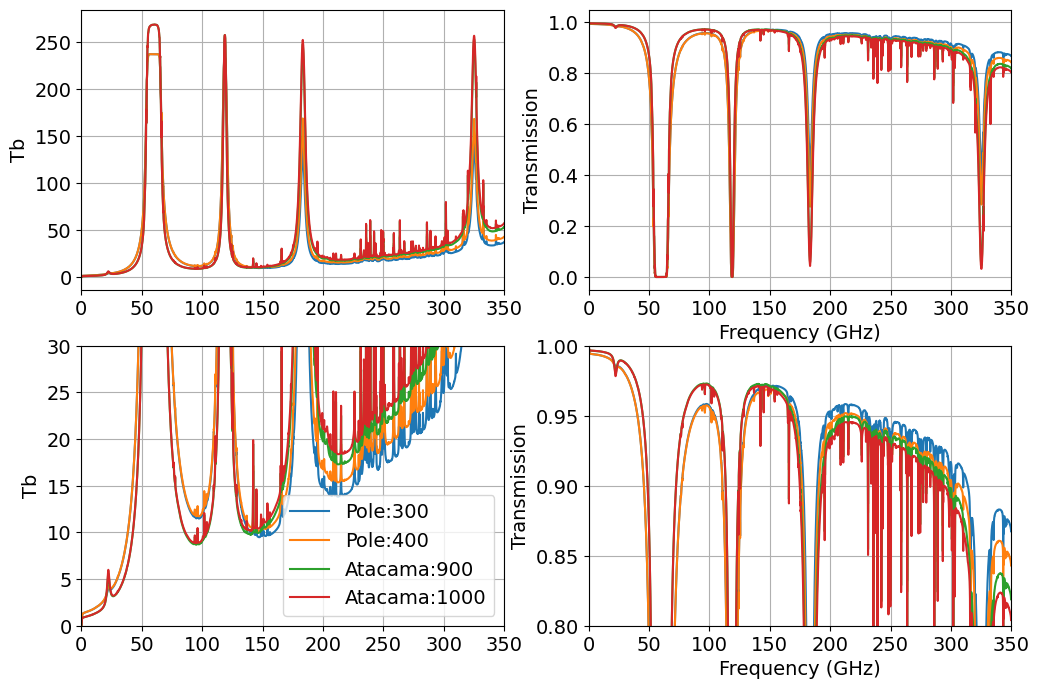

In [2]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

# Read in atmospheric data, plot it to see that it makes sense.
atmos = {}
read_atmospheres(atmos)

numax = 350
plt.subplot(2,2,1)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][4])
plt.ylabel('Tb')
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,2)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.grid()

plt.subplot(2,2,3)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][4],label=pltlabel)
plt.legend()
plt.ylabel('Tb')
plt.xlim(0,numax)
plt.ylim(0,30)
plt.grid()

plt.subplot(2,2,4)
for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][2])
plt.ylabel('Transmission')
plt.xlabel('Frequency (GHz)')
plt.xlim(0,numax)
plt.ylim(0.8,1.0)
plt.grid()



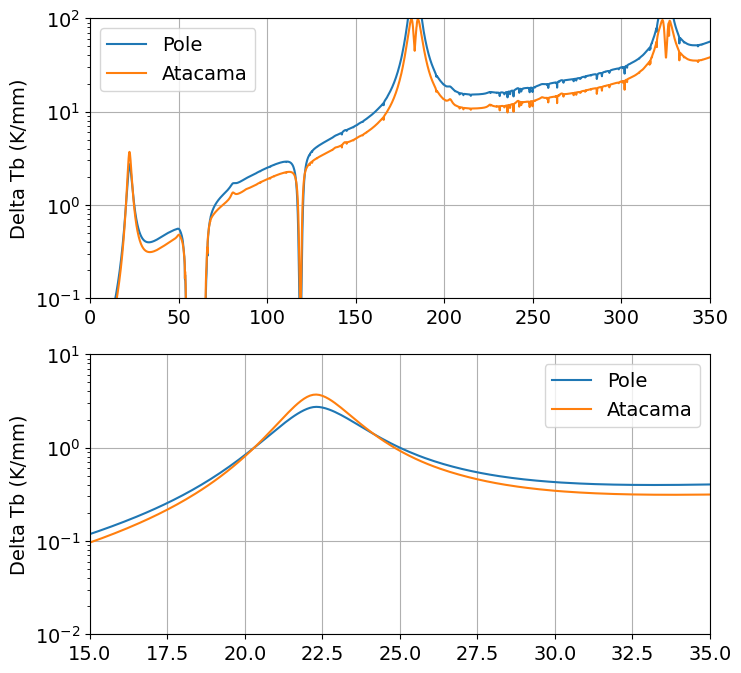

In [3]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 8]

# plot Tb differences between pwvs
nuvec = atmos['Pole'][400][0]
Tbdiff_pole = 10*(atmos['Pole'][400][4]-atmos['Pole'][300][4])  #K/mm
Tbdiff_atacama = 10*(atmos['Atacama'][1000][4]-atmos['Atacama'][900][4])  #K/mm

plt.subplot(2,1,1)
plt.semilogy(nuvec,Tbdiff_pole,label='Pole')
plt.semilogy(nuvec,Tbdiff_atacama,label='Atacama')
plt.ylabel('Delta Tb (K/mm)')
plt.legend()
plt.xlim(0,350)
plt.ylim(0.1,100)
plt.grid()

plt.subplot(2,1,2)
plt.semilogy(nuvec,Tbdiff_pole,label='Pole')
plt.semilogy(nuvec,Tbdiff_atacama,label='Atacama')
plt.ylabel('Delta Tb (K/mm)')
plt.legend()
plt.xlim(15,35)
plt.ylim(0.01,10)
plt.grid()

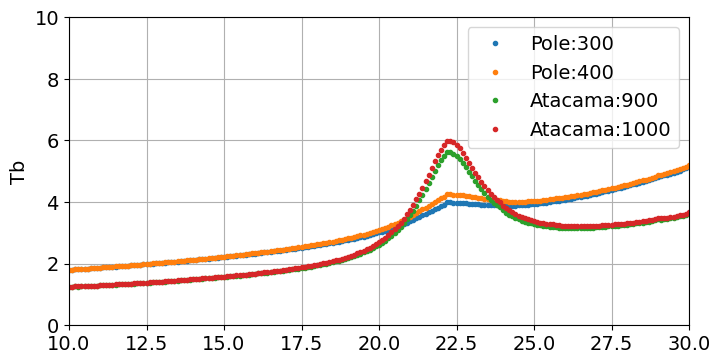

In [4]:
# Look at 22GHz water line more closely.
# Shape of Pole line is weird, maybe suspicious.  Should verify with direct am runs with
# better frequency resolution.

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [8, 4]

numax = 30

for site in ['Pole','Atacama']:
    for pwv in atmos[site].keys():
        pltlabel=site+':'+str(pwv)
        plt.plot(atmos[site][pwv][0],atmos[site][pwv][4],'.',label=pltlabel)
plt.legend()
plt.ylabel('Tb')
#plt.xlim(10,numax)
plt.xlim(10,30)
plt.ylim(0,10)
plt.grid()


In [ ]:
''' this will be necessary when the Jacobian is incorporated
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 6]

figure.set_constrained_layout_pads(w_pad=5 / 72, h_pad=2 / 72, hspace=0.5,
                                wspace=1.0)

plt.subplot(2,3,1)
plt.plot(Atacama[0], Atacama[1]) #tau neper

plt.subplot(2,3,2)
plt.plot(Atacama[0], Atacama[2]) #transmittance

plt.subplot(2,3,3)
plt.plot(Atacama[0], Atacama[3]) #trj K

plt.subplot(2,3,4)
plt.plot(Atacama[0], Atacama[4]) #tb K

plt.subplot(2,3,5)
plt.plot(Atacama[0], Atacama[5]) #? Jacobian of Tb
'''

# Outline

*We've been using jbolo to facilitate the calculation of g_pwv because it then includes all the frequency 
dependence of the optics and the atmophsere.  The major frequency-dependent component of the optics is the 
Lyot stop.  We can treat the problem more generally by considering two designs, for two limits of Lyot-stop
illumination.*

1. Calculate single-moded, single-polarization instrument band response, ie to atmosphere.
  - F_inst($\nu$) = F_detector($\nu$) \* F_lyot($\nu$)
  - F_detector($\nu$) from logistic detector band
  - F_lyot($\nu$) depends on amount of spillover:
    - low spill Lyot stop => nearly frequency independent.
    - high spill lyot stop => efficiency of that is \propto nu^2
  
  
2. Integrate Tb_atmos($\nu$) over F_inst($\nu$) to get dPopt_atmosphere/dpwv.


3. Calculate response to delta_T_cmb
  - F_tot($\nu$) = F_inst($\nu$) * F_atmos($\nu$)
  - Integrate delta_T_cmb over F_tot($\nu$) to get dPopt_cmb/dT_cmb
  
  
4. Take the ratio of those two, g_pwv = (dPopt_atmosphere/dpwv)/(dPopt_cmb/dT_cmb) = dT_cmb/dpwv .

# Read in band information from a yaml file
(using same dictionary format as jbolo, for compatibility)

In [5]:
sim = yaml.safe_load(open('channels.yaml'))

In [6]:
sim['channels']

{'ULF': {'chnum': 0, 'band_center': 20.0, 'nu_low': 17.5, 'nu_high': 22.5},
 'LF_1': {'chnum': 1, 'band_center': 25.75, 'nu_low': 21.5, 'nu_high': 30.0},
 'LF_2': {'chnum': 2, 'band_center': 38.75, 'nu_low': 29.99, 'nu_high': 47.51},
 'MF_1': {'chnum': 3, 'band_center': 91.5, 'nu_low': 77.0, 'nu_high': 106.0},
 'MF_2': {'chnum': 4, 'band_center': 148.5, 'nu_low': 128.0, 'nu_high': 169.0},
 'HF_1': {'chnum': 5,
  'band_center': 227.0,
  'nu_low': 197.94,
  'nu_high': 256.06},
 'HF_2': {'chnum': 6,
  'band_center': 285.5,
  'nu_low': 255.95,
  'nu_high': 315.05}}

Text(0.5, 1.0, 'Model 1: Logistic LF1 Band')

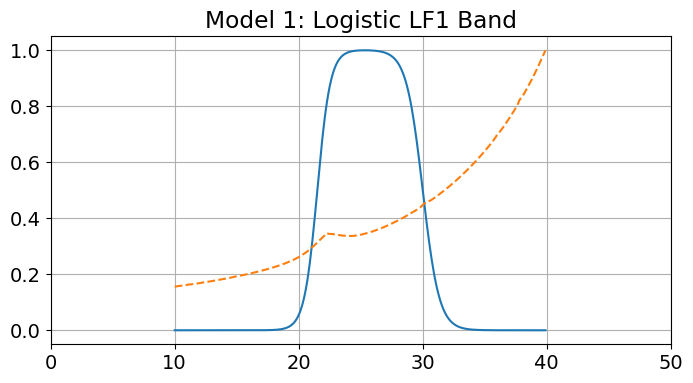

In [7]:
#test run to see band shape with logistic model
# Create our own frequency vector, over which we'll integrate.
# Make the logistic band model directly on that vector.
# Interpolate the atmospheric Tb's to that vector.

nuvec = np.arange(10,40,0.1) # frequency vector, interpolate atmos to this.
dnu= sim['channels']['LF_1']['nu_high']-sim['channels']['LF_1']['nu_low']
bandcenter = sim['channels']['LF_1']['band_center']
bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, 2.0, 0.7)
nu_atmos = atmos['Pole'][300][0]
Tb_atmos = atmos['Pole'][300][4]
Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos)

plt.plot(nuvec,bandmodel)
plt.plot(nuvec,Tb_interp/np.max(Tb_interp),'--')
plt.xlim(0,50)
plt.grid()
plt.title('Model 1: Logistic LF1 Band')

Comment on plot above:

- we might want to make band smaller for LF so we are not integrating over the whole thing (all freq)

# This is where we begin Testing and Incorporating our Python Functions
We first want to define what our model is similar to above, from there we can run the other functions to get specfic values, then we can put them all into a dictionary so we can call them later for plotting.

In [8]:
#This cell defines intial parameters for our instrument band model and atmospheric transmission
#we will be using the new am files for this section, but you can also use CH's data cube or other files

bandcenter = sim['channels']['HF_1']['band_center']
nulow=sim['channels']['HF_1']['nu_low']*0.7
nuhigh=sim['channels']['HF_1']['nu_high']*1.3
nuvec = np.arange(nulow, nuhigh, 0.1) # frequency vector, interpolate atmos to this.
dnu= sim['channels']['HF_1']['nu_high']-sim['channels']['HF_1']['nu_low']
#bandcenter = sim['channels']['LF_2']['band_center']
nu_atmos = atmos['Pole'][300][0]
atmos_trans = atmos['Pole'][300][2]
atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
Tb_atmos1 = atmos['Pole'][300][4]
Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
Tb_atmos2 = atmos['Pole'][400][4]
Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)

a=2
n=0.7
alpha= 2 # 0 or 2

In [9]:
bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)#*atmos_trans
#print(len(bandmodel))
#print(len(atmos_trans_interp))

Text(0.5, 1.0, 'Band Model 2: Logistic+Optics for LF1')

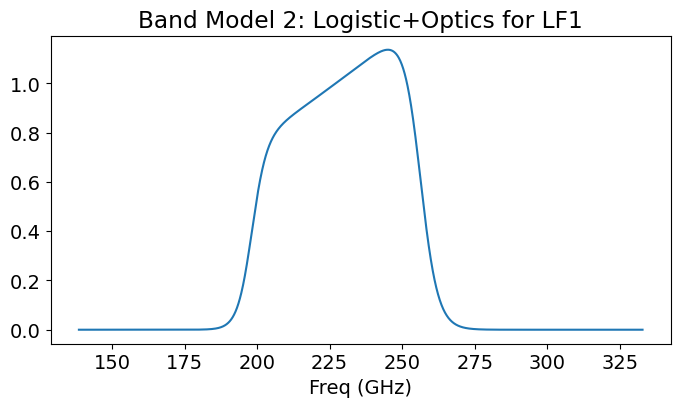

In [10]:
#this is the instrument and optics band model 
plt.plot(nuvec, bandmodel)
plt.xlabel('Freq (GHz)')
plt.title('Band Model 2: Logistic+Optics for LF1')#+ ch)

In [11]:
dpdtcmb= calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
print('dPdTcmb:', dpdtcmb)

dPdTcmb: 4.4870593847306913e-13


In [12]:
dPdpwv= calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, bandmodel, atmos_trans_interp)
print('dPdpwv:', dPdpwv)

dPdpwv: 2.5321403926993923e-11


In [13]:
gpwv= calc_gpwv(dPdpwv, dpdtcmb)
print('gpwv:', gpwv)

gpwv: 56.43206776616728


These are previous gpwv results for Pole at 300 and 400 um pwv:

1.122368744313282, 1.1707764662372104
<br>1.109273860925371, 1.157481276402308
<br>0.43580808244702285, 0.4563716164235642
<br>2.4419921980252965, 2.556993622960584
<br>12.825834088708984, 13.350005243407248
<br>54.11917318835391, 56.17281294172888
<br>166.1904136365731, 170.3894376628703

dPdTcmb:
<br>1.3661235964755087e-13 1.3661235964755087e-13
<br>2.306039014463887e-13 2.306039014463887e-13
<br>4.642291404321928e-13 4.642291404321928e-13
<br>6.445851145073793e-13 6.445851145073793e-13
<br>6.533097901070082e-13 6.533097901070082e-13
<br>4.839831617855115e-13 4.839831617855115e-13
<br>2.69708647175781e-13 2.69708647175781e-13

dPdpwv:
<br>1.5332944255529613e-13 1.5994253567248648e-13
<br>2.558028801018893e-13 2.66919698189518e-13
<br>2.0231481150778365e-13 2.1186100320996165e-13
<br>1.5740718205902628e-12 1.6482000272506868e-12
<br>8.379242976441777e-12 8.721689123497848e-12
<br>2.6192768552917207e-11 2.718669561392404e-11
<br>4.48229916355036e-11 4.595550472509482e-11

Given the results, the functions seem to be working well. Have @John check to make sure fxns are all correct.

In [14]:
#this section visualizes the alpha bandmodel function, play with the alpha parameter (0 or 2)
band=alpha_bandmodel(atmos['Pole'][300][0], sim['channels']['LF_1']['band_center'], 2)

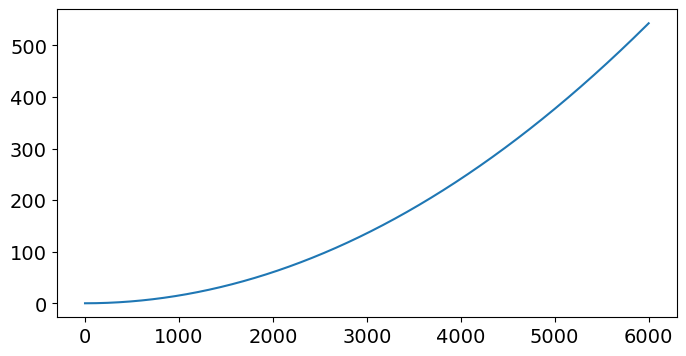

In [15]:
plt.plot(band)

# Calculate and save gpwv values through all bands 
The following cells take portion of previous nbs and calculate gpwv values for each band and then save them into a dictionary where they can be called to plot.

In [19]:
#South Pole Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
spole_pwvs=[300]#, 400]
#for site in ['Pole','Atacama']:
for pwv in spole_pwvs:
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        bandcenter = sim['channels'][ch]['band_center']
        nu_atmos = atmos['Pole'][pwv][0]
        nulow=sim['channels'][ch]['nu_low']
        nuhigh= sim['channels'][ch]['nu_high']
        dnu= nuhigh-nulow
        nuvec = np.arange(nulow*0.7,nuhigh*1.3,0.1)
        atmos_trans = atmos['Pole'][pwv][2]
        atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
        Tb_atmos1 = atmos['Pole'][pwv][4]
        Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
        Tb_atmos2 = atmos['Pole'][pwv+100][4]
        Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)
        bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)
        #pwv2= pwv+100
        dPdpwv = calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, bandmodel, atmos_trans_interp)
        dPdTcmb = calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
        gpwv= dPdpwv/dPdTcmb
        
    
        spole_dict[pwv][ch]['freqvec']= nuvec
        spole_dict[pwv][ch]['tbvec']= Tb_interp
        spole_dict[pwv][ch]['high_edge_0']= nuhigh
        spole_dict[pwv][ch]['low_edge_0']= nulow
        spole_dict[pwv][ch]['bandshape']= bandmodel#*atmos_trans_interp
        spole_dict[pwv][ch]['nu0']= bandcenter
        spole_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        spole_dict[pwv][ch]['dPdpwv']= dPdpwv
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [20]:
for ch in chlist:
    print(spole_dict[300][ch]['gpwv'])
    #print(len(spole_dict[300][ch]['bandshape']))

1.260101913278056
1.0035861429504829
0.4797196373745138
2.708282793099689
14.521588448395063
56.43206776616728
174.38640788509775


These numbers match well with previous dict numbers.

In [22]:
#Atacama dict, run once
a = 2.0
n = 0.7
alpha = 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
atacama_pwvs=[900] #1000

for pwv in atacama_pwvs: #can always add more pwv files and change functions below for pwv
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        bandcenter = sim['channels'][ch]['band_center']
        nu_atmos = atmos['Atacama'][pwv][0]
        nulow=sim['channels'][ch]['nu_low']
        nuhigh= sim['channels'][ch]['nu_high']
        dnu= nuhigh-nulow
        nuvec = np.arange(nulow*0.7,nuhigh*1.3,0.1) 
        atmos_trans = atmos['Atacama'][pwv][2]
        atmos_trans_interp = np.interp(nuvec,nu_atmos,atmos_trans)
        Tb_atmos1 = atmos['Atacama'][pwv][4]
        Tb_interp = np.interp(nuvec,nu_atmos,Tb_atmos1)
        Tb_atmos2 = atmos['Atacama'][pwv+100][4]
        Tb_interp2= np.interp(nuvec,nu_atmos,Tb_atmos2)
        bandmodel = logistic_bandmodel(nuvec, bandcenter, dnu, a, n)*alpha_bandmodel(nuvec, bandcenter, alpha)
        dPdpwv = calc_dPdpwv(nuvec, Tb_interp, Tb_interp2, bandmodel, atmos_trans_interp)
        dPdTcmb = calc_dPdTcmb(nuvec, bandmodel, atmos_trans_interp)
        gpwv= dPdpwv/dPdTcmb


        atacama_dict[pwv][ch]['freqvec']= nuvec
        atacama_dict[pwv][ch]['tbvec']= Tb_interp
        atacama_dict[pwv][ch]['high_edge_0']= nuhigh
        atacama_dict[pwv][ch]['low_edge_0']= nulow
        atacama_dict[pwv][ch]['bandshape']= bandmodel#*atmos_trans_interp
        atacama_dict[pwv][ch]['nu0']= bandcenter
        atacama_dict[pwv][ch]['dPdTcmb']= dPdTcmb
        atacama_dict[pwv][ch]['dPdpwv']= dPdpwv
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)

In [25]:
for ch in chlist:
    print(atacama_dict[900][ch]['gpwv'])
    #print(len(spole_dict[300][ch]['bandshape']))

1.4631690182464063
1.04594408144244
0.37483292005462054
2.0361294136912917
10.361661405416248
40.60972473646332
121.01341137302688


Previous Atacama gpwv dict results:
<br> 1.40016446096226 1.39929244108557
<br> 1.3031377611569213 1.30269499706147
<br> 0.36135153019617233 0.36274598973346694
<br> 1.94921215916745 1.9574752703150706
<br> 10.068814008570262 10.057970033062979
<br> 42.777747997802265 42.669275098035016
<br> 136.2759078220992 134.16166983811976

## Next Steps: Plotting and Data Visualization

Text(0.5, 1.0, 'Pole: All Bands')

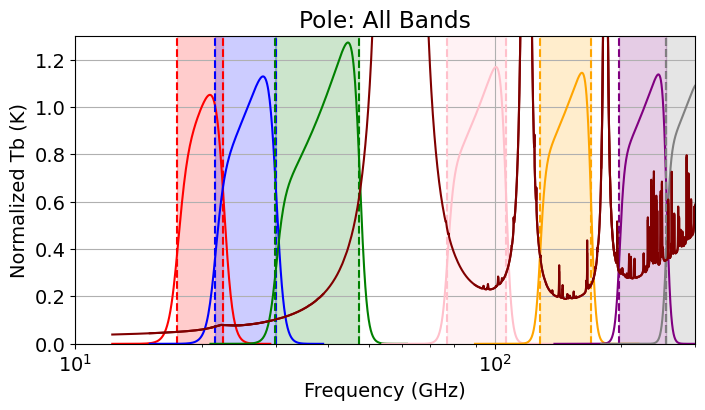

In [28]:
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=spole_dict[300][ch]['high_edge_0']
    x2=spole_dict[300][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    plt.semilogx(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.semilogx(spole_dict[300][ch]['freqvec'], spole_dict[300][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 300)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Pole: All Bands')

Text(0.5, 1.0, 'Atacama: All Bands')

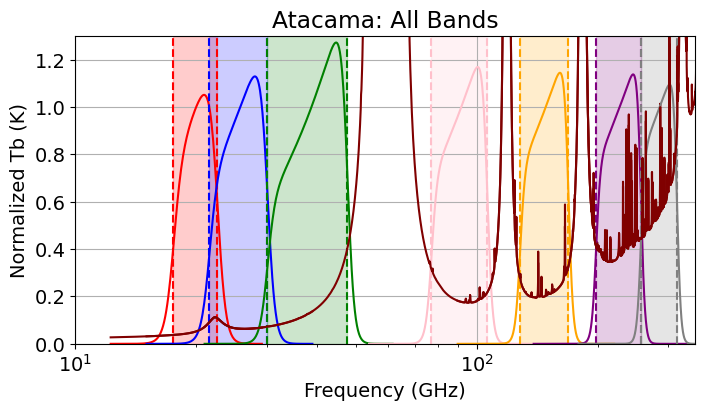

In [29]:
bandtype_dict= {'ULF':'red', 'LF_1': 'blue', 'LF_2': 'green', 'MF_1': 'pink', 'MF_2': 'orange', 'HF_1': 'purple', 'HF_2': 'grey'}
bandarray=list(bandtype_dict.keys())

#for band in bands['SAT'].keys():
    
for ch in chlist:   
    btype=bandtype_dict[ch]
    x1=atacama_dict[900][ch]['high_edge_0']
    x2=atacama_dict[900][ch]['low_edge_0']
    plt.axvline(x = x1, color=btype, linestyle='dashed', markersize= 0.5)#, label = 'upper band edge')
    plt.axvline(x = x2, color=btype, linestyle='dashed', markersize= 0.5)
        #plt.fill_between(x1, x2, color='blue', alpha=.2)
    plt.axvspan(x1, x2, alpha=0.2, color=btype) 
    
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['bandshape'], color=btype, label='Logistic Band Model')
    plt.semilogx(atacama_dict[900][ch]['freqvec'], atacama_dict[900][ch]['tbvec']/50, color='maroon', linestyle='solid', markersize= 0.15)
#note that model 1 includes optics/lyot info and instrumentation info
plt.xlim(10, 350)
plt.ylim(0, 1.3)
plt.grid()
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Tb (K)')
plt.title('Atacama: All Bands')


## Edge Placement with new Functions
The cells below display results from two edge functions one high and one low. It allows us to look at the edges of our observing bands, similar to previous functions above, but we add in high/low band edges and remove the center frequency.

By properly using these functions we can adjust the dictionaries above for the two sites with not only gpwv values but also the gpwv values as a function of high and low edges.

In [6]:
#this function returns 2 arrays
dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels']['LF_1']['nu_low'], sim['channels']['LF_1']['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, 2, 0.7, 2)
gpwv_h = dPdpwv_h/dPdTcmb_h

In [21]:
#print(gpwv_h)

In [22]:
#this function returns 2 arrays
dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels']['LF_1']['nu_low'], sim['channels']['LF_1']['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, 2, 0.7, 2)
gpwv_l=dPdpwv_l/dPdTcmb_l
#print(gpwv_l)

## Two New Dictionaries
One dict for Pole and one dict for Atacama.  These hold all the information needed for gpwv values and edges.

In [24]:
# NEW South Pole Dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
spole_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Pole'].keys(): #can always add more pwv files and change functions below to [pwv] instead of [300] and [pwv+100] instead of [400]
    spole_dict[pwv]={}
    for ch in chlist:
        spole_dict[pwv][ch]={}
        npts=50 #make sure this is same as in function
        
        nu_low = sim['channels'][ch]['nu_low']
        nu_high = sim['channels'][ch]['nu_high']
        dnu = nu_high-nu_low
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Pole'][pwv][0]
        freqvec_low= np.linspace(nu_low-(nu_low*0.1), nu_low+(nu_low*0.1), npts)
        freqvec_high= np.linspace(nu_high-(nu_high*0.1), nu_high+(nu_high*0.1), npts)
        
        tbvec = atmos['Pole'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        
        dPdpwv = calc_dPdpwv(atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Pole'][300][0], atmos['Pole'][400][0], nu0, dnu, a, n, alpha)
        gpwv = dPdpwv/dPdTcmb
        
        dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, a, n, alpha)
        gpwv_l = dPdpwv_l/dPdTcmb_l
        dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Pole'][300][0], atmos['Pole'][400][0], atmos['Pole'][300][1], atmos['Pole'][400][1], dnu, a, n, alpha)
        gpwv_h= dPdpwv_h/dPdTcmb_h
        
        spole_dict[pwv][ch]['freqvec']= freqvec
        spole_dict[pwv][ch]['lowvec']= freqvec_low
        spole_dict[pwv][ch]['highvec']=freqvec_high
        
        spole_dict[pwv][ch]['tbvec']= tbvec
        spole_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        spole_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        spole_dict[pwv][ch]['bandshape']= model1
        spole_dict[pwv][ch]['nu0']= nu0
        
        spole_dict[pwv][ch]['dPdTcmb'] = dPdTcmb
        spole_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        spole_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        spole_dict[pwv][ch]['dPdpwv'] = dPdpwv
        spole_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        spole_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        spole_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        spole_dict[pwv][ch]['gpwv_l'] = gpwv_l
        spole_dict[pwv][ch]['gpwv_h'] = gpwv_h
    

In [29]:
# NEW Atacama dict, run once
a = 2.0
n = 0.7
alpha= 2  #can be 0 or 2

chlist = list(sim['channels'].keys())
atacama_dict={}
#for site in ['Pole','Atacama']:
for pwv in atmos['Atacama'].keys(): #can always add more pwv files and change functions below to [pwv] instead of [900]
    atacama_dict[pwv]={}
    for ch in chlist:
        atacama_dict[pwv][ch]={}
        npts=50 #make sure this is same as in function
        
        nu_low = sim['channels'][ch]['nu_low']
        nu_high = sim['channels'][ch]['nu_high']
        dnu = nu_high-nu_low
        nu0 = sim['channels'][ch]['band_center']
        freqvec = atmos['Atacama'][pwv][0]
        freqvec_low= np.linspace(nu_low-(nu_low*0.1), nu_low+(nu_low*0.1), npts)
        freqvec_high= np.linspace(nu_high-(nu_high*0.1), nu_high+(nu_high*0.1), npts)
        
        tbvec = atmos['Atacama'][pwv][1]
        model1 = logistic_bandmodel(freqvec, nu0, dnu, a, n)*alpha_bandmodel(freqvec, nu0, alpha)
        
        dPdpwv = calc_dPdpwv(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], nu0, dnu, a, n, alpha)
        dPdTcmb = calc_dPdTcmb(atmos['Atacama'][900][0], atmos['Atacama'][1000][0], nu0, dnu, a, n, alpha)
        gpwv = dPdpwv/dPdTcmb
        
        dPdTcmb_l, dPdpwv_l = calc_lowedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], dnu, a, n, alpha)
        gpwv_l = dPdpwv_l/dPdTcmb_l
        dPdTcmb_h, dPdpwv_h = calc_highedgevalues(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], atmos['Atacama'][900][0], atmos['Atacama'][1000][0], atmos['Atacama'][900][1], atmos['Atacama'][1000][1], dnu, a, n, alpha)
        gpwv_h= dPdpwv_h/dPdTcmb_h
        
        atacama_dict[pwv][ch]['freqvec']= freqvec
        atacama_dict[pwv][ch]['lowvec']= freqvec_low
        atacama_dict[pwv][ch]['highvec']=freqvec_high
        
        atacama_dict[pwv][ch]['tbvec']= tbvec
        atacama_dict[pwv][ch]['high_edge_0']= sim['channels'][ch]['nu_high']
        atacama_dict[pwv][ch]['low_edge_0']= sim['channels'][ch]['nu_low']
        atacama_dict[pwv][ch]['bandshape']= model1
        atacama_dict[pwv][ch]['nu0']= nu0
        
        atacama_dict[pwv][ch]['dPdTcmb'] = dPdTcmb
        atacama_dict[pwv][ch]['dPdTcmb_l'] = dPdTcmb_l
        atacama_dict[pwv][ch]['dPdTcmb_h'] = dPdTcmb_h
        
        atacama_dict[pwv][ch]['dPdpwv'] = dPdpwv
        atacama_dict[pwv][ch]['dPdpwv_l'] = dPdpwv_l
        atacama_dict[pwv][ch]['dPdpwv_h'] = dPdpwv_h
        
        atacama_dict[pwv][ch]['gpwv']= (dPdpwv/dPdTcmb)
        atacama_dict[pwv][ch]['gpwv_l'] = gpwv_l
        atacama_dict[pwv][ch]['gpwv_h'] = gpwv_h

## Visualizing these results

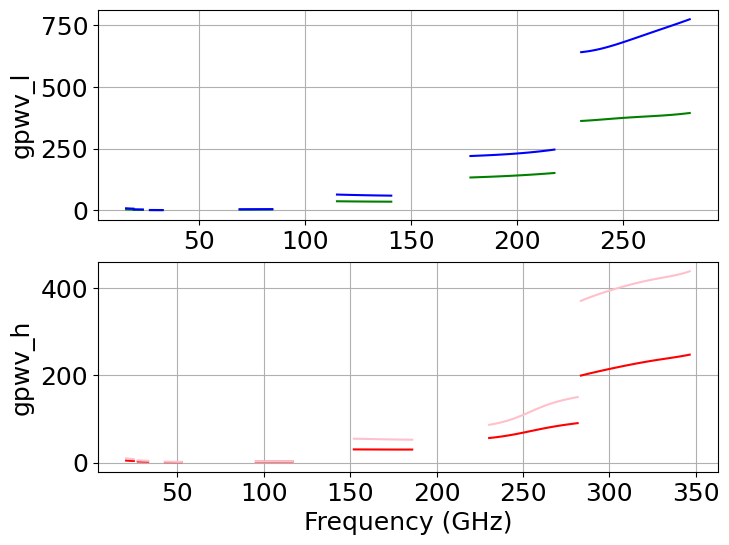

In [39]:
#comparison of the two sites and their respective gpwv high and low values
plt.subplot(2,1,1)
for ch in chlist:
    plt.plot(atacama_dict[900][ch]['lowvec'], atacama_dict[900][ch]['gpwv_l'], color='green')
    plt.plot(spole_dict[300][ch]['lowvec'], spole_dict[300][ch]['gpwv_l'], color='blue')
plt.ylabel('gpwv_l')
plt.grid()

plt.subplot(2,1,2)
for ch in chlist:
    plt.plot(atacama_dict[900][ch]['highvec'], atacama_dict[900][ch]['gpwv_h'], color='red')
    plt.plot(spole_dict[300][ch]['highvec'], spole_dict[300][ch]['gpwv_h'], color='pink')
plt.ylabel('gpwv_h')
plt.xlabel('Frequency (GHz)')
plt.grid()
    
#plt.legend()

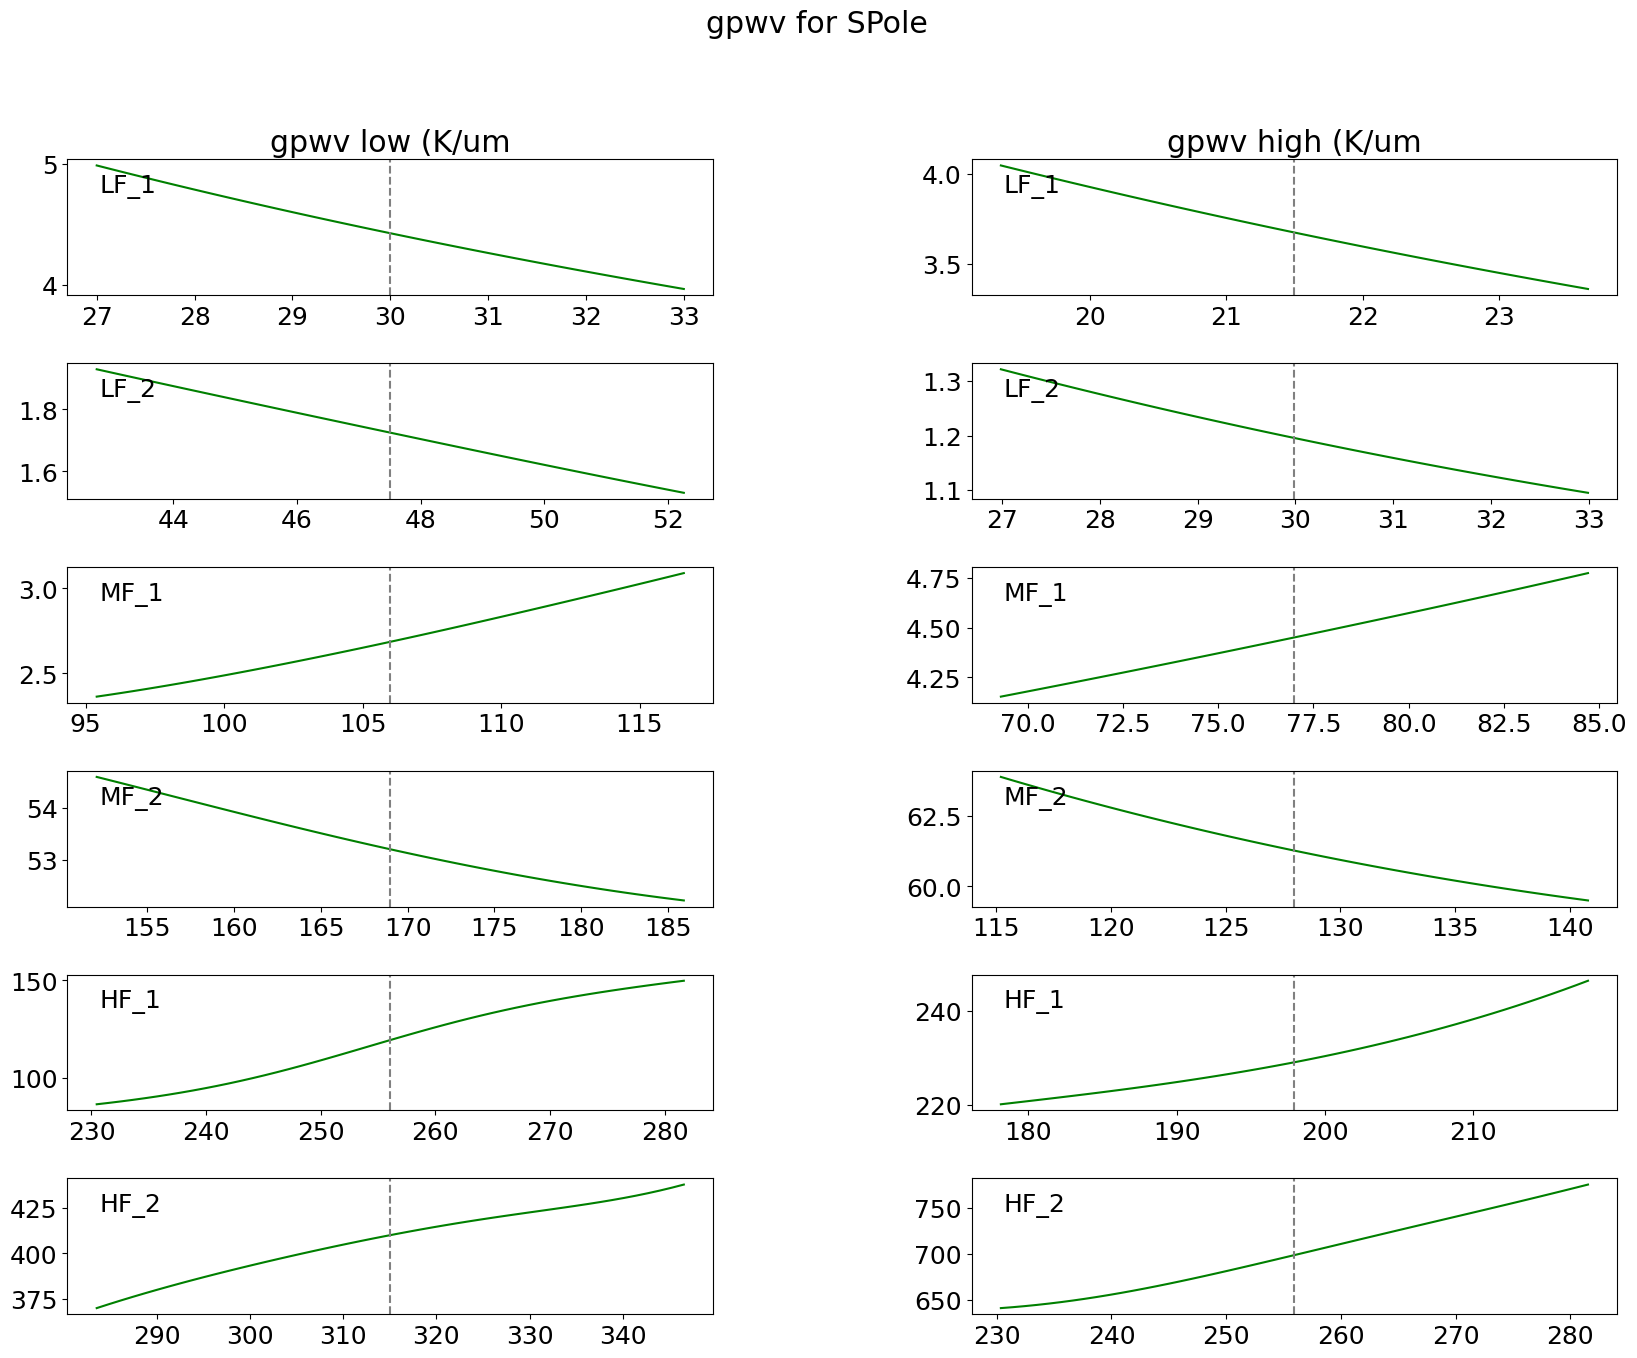

In [59]:
#SPole plots
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {300: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for SPole')#,fontsize=20)
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv low (K/um)')
axis[0,1].set_title('gpwv high (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [300]
Atacama_pwvs= [900]

for pwv in Pole_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(spole_dict[pwv][ch]['highvec'], spole_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)
            axis[ii2, ii1].axvline(x = spole_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(spole_dict[pwv][ch]['lowvec'], spole_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = spole_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii3, ii2].set_xlabel('Frequency (GHz)', loc='center')

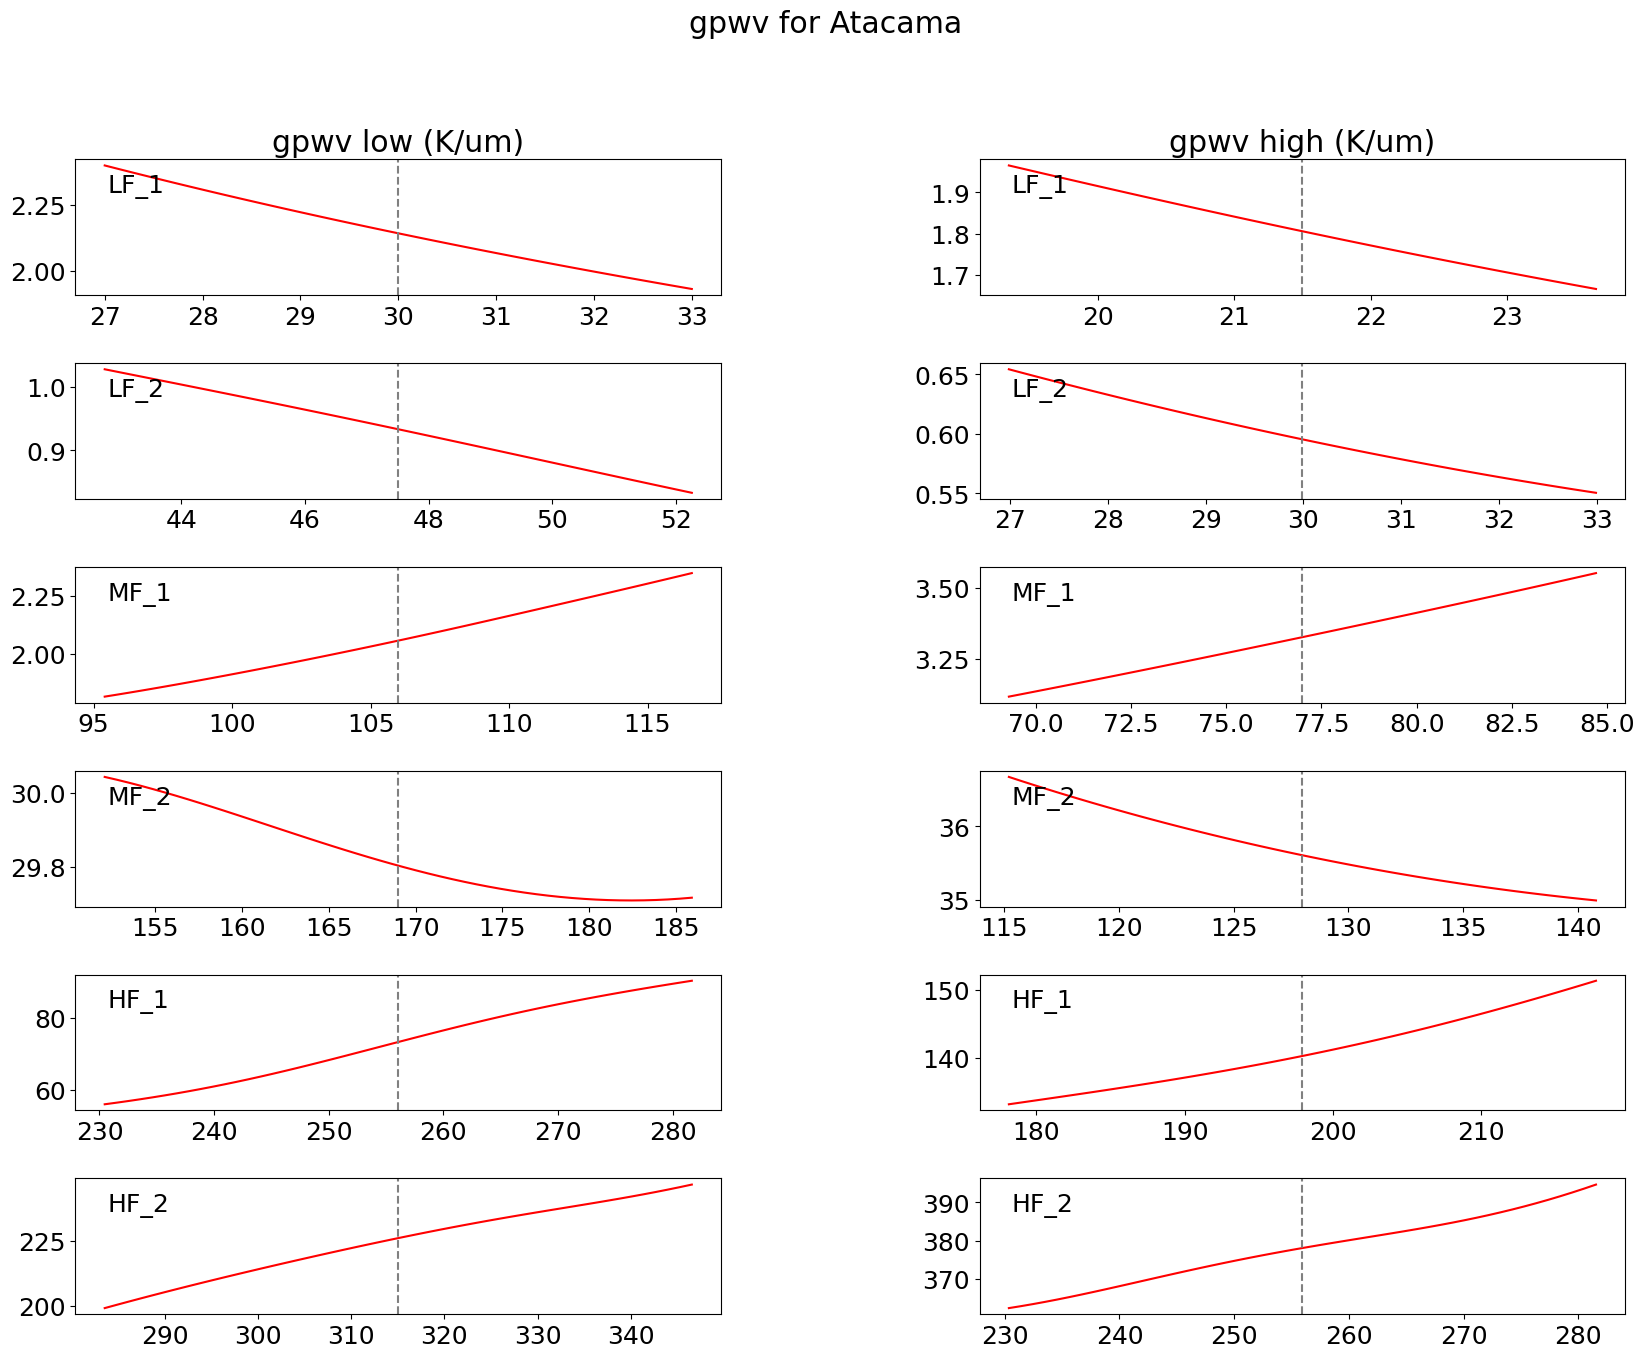

In [60]:
#Atacama plots 
ii1_dict= {'LF_1':0, 'LF_2':0, 'MF_1':0, 'MF_2':0, 'HF_1':0, 'HF_2':0} #'LF1':0, 'LF2':0, }
ii3_dict= {'LF_1':1, 'LF_2':1, 'MF_1':1, 'MF_2':1, 'HF_1':1, 'HF_2':1}
ii2_dict=  {'LF_1':0, 'LF_2':1, 'MF_1':2, 'MF_2':3, 'HF_1':4, 'HF_2':5} #, 'w188':1, 'w203':2, 'w204': 3, 'w206':4}
bandarray=list(ii1_dict.keys())
pwvtype_dict= {400: 'g', 900: 'r', 2200: 'b'}
figure, axis = plt.subplots(6, 2, figsize=(20,15))

figure.subplots_adjust(hspace=0.5, wspace=0.4)
figure.suptitle('gpwv for Atacama')#,fontsize=20)
#figure.text(0.5, 0.08, 'Frequency (GHz)', ha='center')
figure.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
axis[0,0].set_title('gpwv low (K/um)')
axis[0,1].set_title('gpwv high (K/um)')

#figure.text(0.08, 0.3, 'dt_cmb/dpwv (low)', va='center', rotation='vertical')
#figure.text(0.08, 0.7, 'dt_cmb/dpwv (high)', va='center', rotation='vertical')

Pole_pwvs= [400]
Atacama_pwvs= [900]

for pwv in Atacama_pwvs:
    for ch in chlist:
        if ch != 'ULF':
            pwvtype= pwvtype_dict[pwv]
            ii1= ii1_dict[ch]
            ii2= ii2_dict[ch] 
            ii3= ii3_dict[ch] 
            axis[ii2, ii1].plot(atacama_dict[pwv][ch]['highvec'], atacama_dict[pwv][ch]['gpwv_h'], pwvtype, markersize= 3)
            axis[ii2, ii1].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii1].transAxes)

            axis[ii2, ii1].axvline(x = atacama_dict[pwv][ch]['high_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            axis[ii2, ii3].plot(atacama_dict[pwv][ch]['lowvec'], atacama_dict[pwv][ch]['gpwv_l'], pwvtype, markersize= 3)
            axis[ii2, ii3].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axis[ii2,ii3].transAxes)
            axis[ii2, ii3].axvline(x = atacama_dict[pwv][ch]['low_edge_0'], color='grey', linestyle='dashed', label = 'upper band edge')
            #axis[ii2, ii3].set_xlabel('Frequency (GHz)', loc='center')

# 2D color contour plots
of g_pwv vs band center and bandwidth

First version (Pole, Atacama):
  - run band center from log(10 to 300GHz),
  - calculate for 1 to 40% fractional bandwidth
  - colorbar is linear in g_pwv
  - square bands

More versions:
 - logistic band (no alpha model)
 - logistic band (with alpha = 2 model)